## Import Required library

In [35]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from prophet import Prophet
from datetime import datetime

## Read clean data

In [36]:
#Read cleaned emission and carbon captured data
emission_cc_data = pd.read_csv('data\cleaned_data.csv')

In [37]:
#print data set info
emission_cc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   country          107 non-null    object 
 1   year             107 non-null    int64  
 2   total_ghg        107 non-null    float64
 3   max_capacity_mt  107 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 3.5+ KB


In [38]:
#look for missing values
emission_cc_data.isna().sum()

country            0
year               0
total_ghg          0
max_capacity_mt    0
dtype: int64

In [39]:
#data stastics
emission_cc_data.describe()

,year,total_ghg,max_capacity_mt
count,107.000000,107.000000,107.000000
mean,2018.504673,681.724393,8.330838
std,4.107916,1519.713665,16.054493
min,2007.000000,0.000000,0.000000
25%,2018.000000,0.000000,0.750000
50%,2020.000000,39.180000,2.650000
75%,2021.500000,505.135000,8.300000
max,2022.000000,5634.800000,96.735000


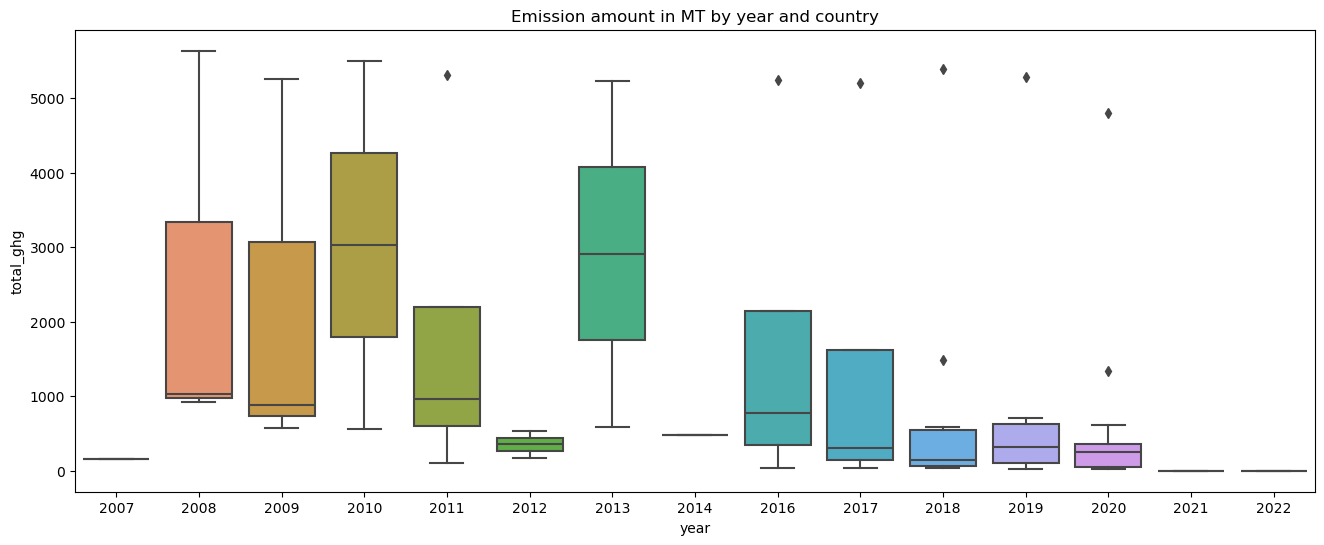

In [40]:
#look for outliers using boxplot for both carbon capture
warnings.filterwarnings("ignore")
plt.figure(figsize=(16, 6))
sns.boxplot(x='year', y='total_ghg', data=emission_cc_data)
plt.title('Emission amount in MT by year and country')
plt.show()

In [41]:
#Convert Year to date data type
emission_cc_data['year'] = emission_cc_data['year'].apply(lambda year: datetime(int(year), 12, 31))
emission_cc_data

,country,year,total_ghg,max_capacity_mt
0,Australia,2009-12-31,578.99,4.00000
1,Australia,2010-12-31,562.21,5.91000
2,Australia,2018-12-31,586.60,4.51000
3,Australia,2019-12-31,577.24,21.70000
4,Australia,2021-12-31,0.00,22.55000
...,...,...,...,...
102,United States,2018-12-31,5384.61,4.30000
103,United States,2019-12-31,5279.34,14.90000
104,United States,2020-12-31,4798.22,16.46145
105,United States,2021-12-31,0.00,72.19900


In [42]:
# filter data to remove 2007 - 2020
emission_cc_data = emission_cc_data.loc[emission_cc_data['year'] <= '2020-01-01']

#filter united states
us_data = emission_cc_data.loc[emission_cc_data['country'] == 'United States']

#filter rest of the world data
rest_world_data = emission_cc_data.loc[emission_cc_data['country'] != 'United States']

#print us data
display(us_data.head())

#print rest of the world data
display(rest_world_data.head())

,country,year,total_ghg,max_capacity_mt
95,United States,2008-12-31,5634.80,7.8200
96,United States,2009-12-31,5255.68,7.8300
97,United States,2010-12-31,5500.53,1.0569
98,United States,2011-12-31,5304.66,1.2000
99,United States,2013-12-31,5234.12,14.0000


,country,year,total_ghg,max_capacity_mt
0,Australia,2009-12-31,578.99,4.000
1,Australia,2010-12-31,562.21,5.910
2,Australia,2018-12-31,586.60,4.510
3,Australia,2019-12-31,577.24,21.700
8,Belgium,2011-12-31,100.54,0.125


In [43]:
#Aggregate data to year and 
#us data
yearly_us_data = us_data.groupby('year').aggregate({'total_ghg':'sum','max_capacity_mt':'sum'}).reset_index()

#rest of world data
yearly_world_data = rest_world_data.groupby('year').aggregate({'total_ghg':'sum','max_capacity_mt':'sum'}).reset_index()

#print head
display(yearly_us_data.head())

display(yearly_world_data.head())

,year,total_ghg,max_capacity_mt
0,2008-12-31,5634.80,7.8200
1,2009-12-31,5255.68,7.8300
2,2010-12-31,5500.53,1.0569
3,2011-12-31,5304.66,1.2000
4,2013-12-31,5234.12,14.0000


,year,total_ghg,max_capacity_mt
0,2007-12-31,158.13,0.800
1,2008-12-31,1948.84,1.100
2,2009-12-31,1464.53,5.200
3,2010-12-31,562.21,5.910
4,2011-12-31,2032.84,26.145


## Predictive analysis for emission and carbon capture data using prophet 

In [44]:
#separate data to green hous gas and carbon capture for united 
us_emission, us_cc = yearly_us_data[['year','total_ghg']], yearly_us_data[['year','max_capacity_mt']]

#rename columns to ds and y
us_emission.rename(columns={'year':'ds','total_ghg':'y'},inplace= True)
us_cc.rename(columns={'year':'ds','max_capacity_mt':'y'},inplace= True)

display(us_emission.head())
display(us_cc.head())

,ds,y
0,2008-12-31,5634.80
1,2009-12-31,5255.68
2,2010-12-31,5500.53
3,2011-12-31,5304.66
4,2013-12-31,5234.12


,ds,y
0,2008-12-31,7.8200
1,2009-12-31,7.8300
2,2010-12-31,1.0569
3,2011-12-31,1.2000
4,2013-12-31,14.0000


In [45]:
#Create a prophet model instance 
us_emission_model = Prophet()
us_cc_model = Prophet()

#fit models
us_emission_model.fit(us_emission)
us_cc_model.fit(us_cc)

#Create future data
future_dataframe = us_cc_model.make_future_dataframe(periods=12,freq = 'y')

future_dataframe.head()

19:48:28 - cmdstanpy - INFO - Chain [1] start processing
19:48:28 - cmdstanpy - INFO - Chain [1] done processing
19:48:28 - cmdstanpy - INFO - Chain [1] start processing
19:48:28 - cmdstanpy - INFO - Chain [1] done processing


,ds
0,2008-12-31
1,2009-12-31
2,2010-12-31
3,2011-12-31
4,2013-12-31


In [46]:
#Make prediction
us_emission_forecast = us_emission_model.predict(future_dataframe)
us_cc_forecast = us_cc_model.predict(future_dataframe)

#print both forecast
display(us_emission_forecast.head(5))
display(us_cc_forecast.head(5))

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2008-12-31,1935.114286,5317.692199,5601.514418,1935.114286,1935.114286,3521.896593,3521.896593,3521.896593,3521.896593,3521.896593,3521.896593,0.0,0.0,0.0,5457.010879
1,2009-12-31,1916.469721,5253.897797,5551.921864,1916.469721,1916.469721,3487.364441,3487.364441,3487.364441,3487.364441,3487.364441,3487.364441,0.0,0.0,0.0,5403.834162
2,2010-12-31,1897.825157,5230.407053,5540.783870,1897.825157,1897.825157,3487.682257,3487.682257,3487.682257,3487.682257,3487.682257,3487.682257,0.0,0.0,0.0,5385.507414
3,2011-12-31,1879.180593,5258.751893,5543.076216,1879.180593,1879.180593,3522.803518,3522.803518,3522.803518,3522.803518,3522.803518,3522.803518,0.0,0.0,0.0,5401.984111
4,2013-12-31,1842.269223,5184.663605,5465.030541,1842.269223,1842.269223,3487.364441,3487.364441,3487.364441,3487.364441,3487.364441,3487.364441,0.0,0.0,0.0,5329.633664


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2008-12-31,0.458942,-0.001270,11.018319,0.458942,0.458942,5.223321,5.223321,5.223321,5.223321,5.223321,5.223321,0.0,0.0,0.0,5.682264
1,2009-12-31,0.801618,-0.263158,11.116141,0.801618,0.801618,4.674473,4.674473,4.674473,4.674473,4.674473,4.674473,0.0,0.0,0.0,5.476091
2,2010-12-31,1.144294,-0.470859,10.823571,1.144294,1.144294,4.129325,4.129325,4.129325,4.129325,4.129325,4.129325,0.0,0.0,0.0,5.273619
3,2011-12-31,1.486969,-0.318429,10.664622,1.486969,1.486969,3.588546,3.588546,3.588546,3.588546,3.588546,3.588546,0.0,0.0,0.0,5.075515
4,2013-12-31,2.173259,1.292809,12.442915,2.173259,2.173259,4.674473,4.674473,4.674473,4.674473,4.674473,4.674473,0.0,0.0,0.0,6.847732


Text(0.5, 1.0, 'United States Carbon Capture Forecast')

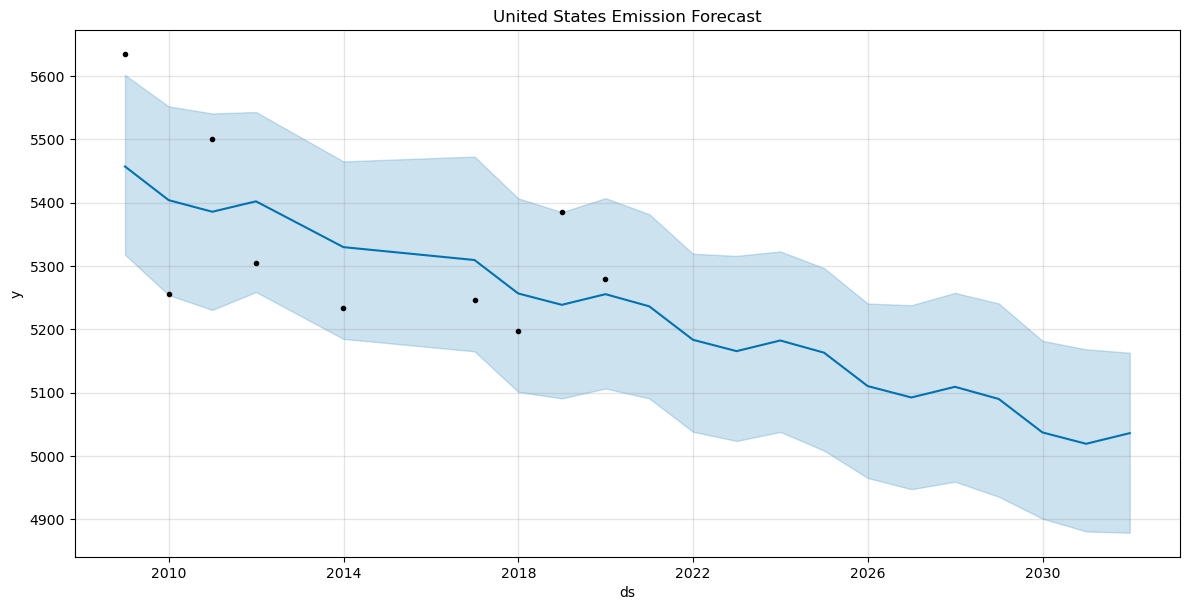

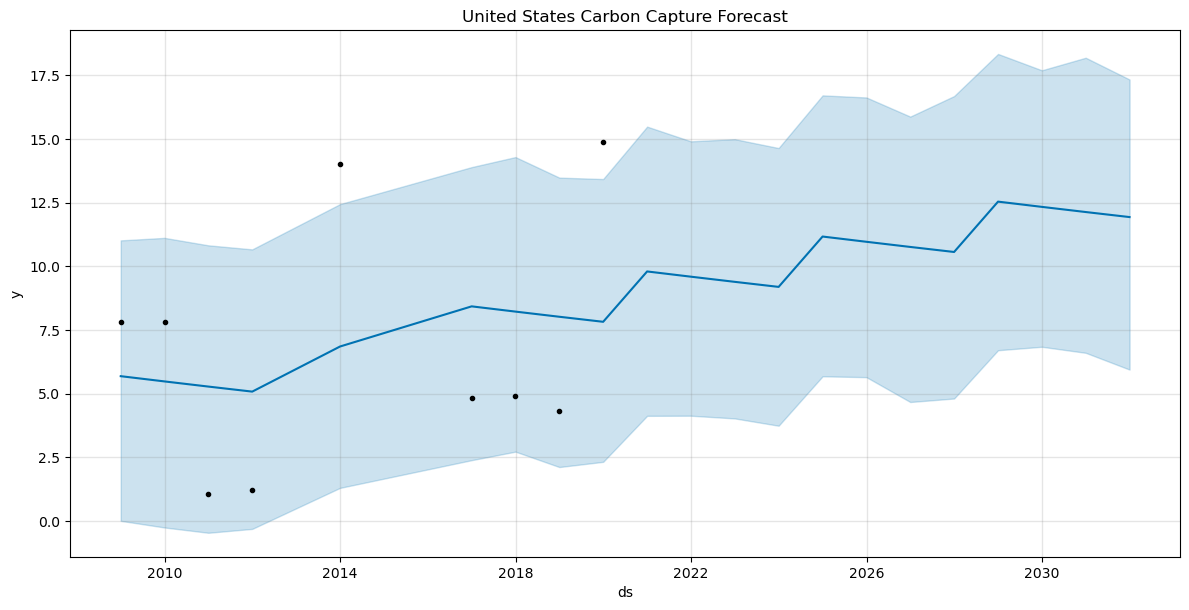

In [47]:
#plot forecast us emission and carbon capture data

us_emission_model.plot(us_emission_forecast,figsize= (12,6))
plt.title("United States Emission Forecast")

us_cc_model.plot(us_cc_forecast,figsize= (12,6))
plt.title("United States Carbon Capture Forecast")

## Predictive analysis for emission and carbon capture data using prophet rest of the world

In [48]:
#separate data to green hous gas and carbon capture for united 
world_emission, world_cc = yearly_world_data[['year','total_ghg']], yearly_world_data[['year','max_capacity_mt']]

#rename columns to ds and y
world_emission.rename(columns={'year':'ds','total_ghg':'y'},inplace= True)
world_cc.rename(columns={'year':'ds','max_capacity_mt':'y'},inplace= True)

display(world_emission.head())
display(world_cc.head())

,ds,y
0,2007-12-31,158.13
1,2008-12-31,1948.84
2,2009-12-31,1464.53
3,2010-12-31,562.21
4,2011-12-31,2032.84


,ds,y
0,2007-12-31,0.800
1,2008-12-31,1.100
2,2009-12-31,5.200
3,2010-12-31,5.910
4,2011-12-31,26.145


In [49]:
#Create a prophet model instance 
world_emission_model = Prophet()
world_cc_model = Prophet()

#fit models
world_emission_model.fit(world_emission)
world_cc_model.fit(world_cc)

19:48:31 - cmdstanpy - INFO - Chain [1] start processing
19:48:31 - cmdstanpy - INFO - Chain [1] done processing
19:48:31 - cmdstanpy - INFO - Chain [1] start processing
19:48:31 - cmdstanpy - INFO - Chain [1] done processing


In [50]:
#Make prediction
world_emission_forecast = world_emission_model.predict(future_dataframe)
world_cc_forecast = world_cc_model.predict(future_dataframe)

#print both forecast
display(world_emission_forecast.head(5))
display(world_cc_forecast.head(5))

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2008-12-31,606.725751,-475.696025,1661.709520,606.725751,606.725751,-3.106621,-3.106621,-3.106621,-3.106621,-3.106621,-3.106621,0.0,0.0,0.0,603.619130
1,2009-12-31,723.817674,-244.723227,1838.332240,723.817674,723.817674,115.043744,115.043744,115.043744,115.043744,115.043744,115.043744,0.0,0.0,0.0,838.861418
2,2010-12-31,840.909597,67.328424,2157.516618,840.909597,840.909597,242.931815,242.931815,242.931815,242.931815,242.931815,242.931815,0.0,0.0,0.0,1083.841412
3,2011-12-31,958.001520,296.789805,2280.720497,958.001520,958.001520,380.401697,380.401697,380.401697,380.401697,380.401697,380.401697,0.0,0.0,0.0,1338.403217
4,2013-12-31,1192.506163,212.976907,2300.417927,1192.506163,1192.506163,115.043744,115.043744,115.043744,115.043744,115.043744,115.043744,0.0,0.0,0.0,1307.549907


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2008-12-31,23.559025,-27.332012,1.207723,23.559025,23.559025,-36.669766,-36.669766,-36.669766,-36.669766,-36.669766,-36.669766,0.0,0.0,0.0,-13.110741
1,2009-12-31,26.240384,-17.497095,11.326769,26.240384,26.240384,-28.503791,-28.503791,-28.503791,-28.503791,-28.503791,-28.503791,0.0,0.0,0.0,-2.263408
2,2010-12-31,28.921742,-4.839087,23.838232,28.921742,28.921742,-19.881792,-19.881792,-19.881792,-19.881792,-19.881792,-19.881792,0.0,0.0,0.0,9.039951
3,2011-12-31,31.603101,5.806608,36.127202,31.603101,31.603101,-10.814236,-10.814236,-10.814236,-10.814236,-10.814236,-10.814236,0.0,0.0,0.0,20.788865
4,2013-12-31,36.973164,-6.452500,22.121696,36.973164,36.973164,-28.503791,-28.503791,-28.503791,-28.503791,-28.503791,-28.503791,0.0,0.0,0.0,8.469373


Text(0.5, 1.0, 'world Carbon Capture Forecast')

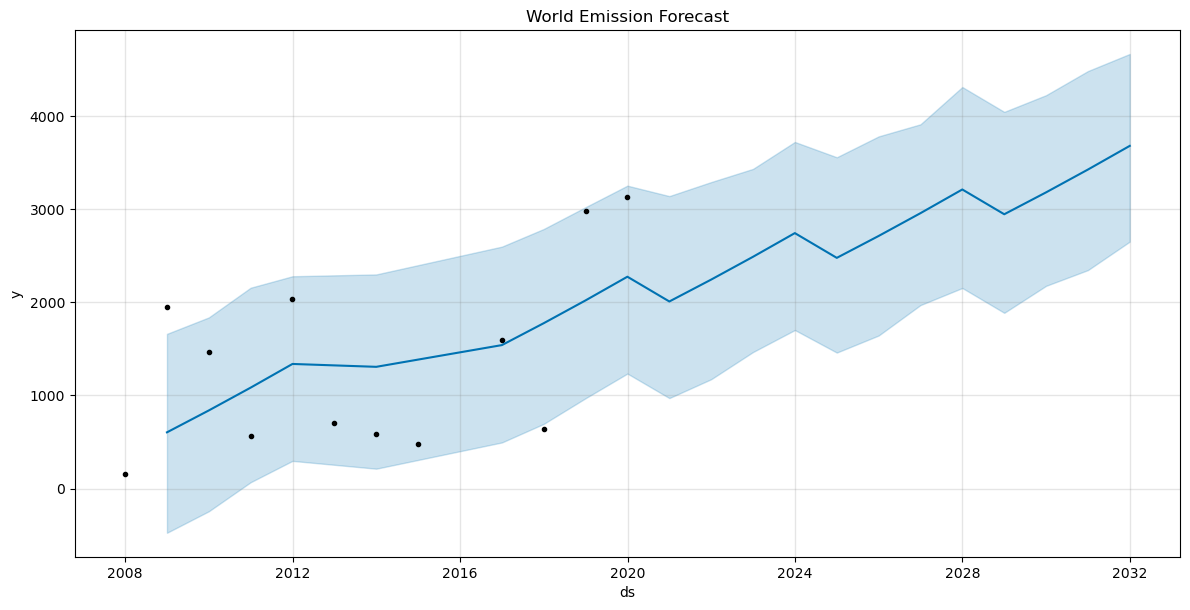

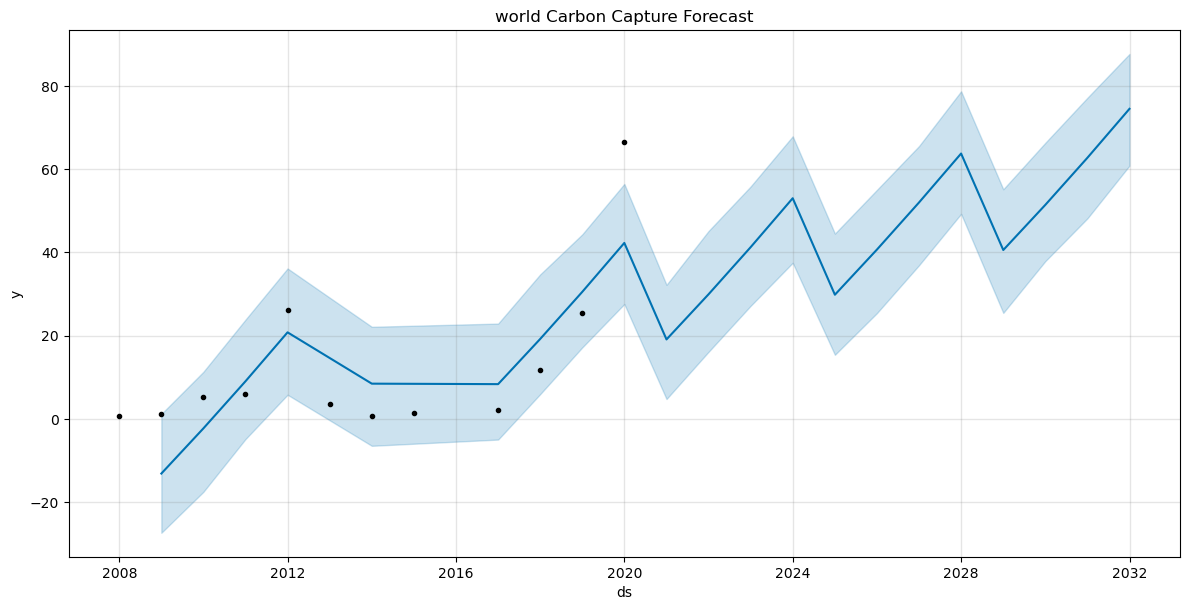

In [51]:
#plot forecast us emission and carbon capture data

world_emission_model.plot(world_emission_forecast,figsize= (12,6))
plt.title("World Emission Forecast")

world_cc_model.plot(world_cc_forecast,figsize= (12,6))
plt.title("world Carbon Capture Forecast")

## Compare US vs The rest of the world forecast

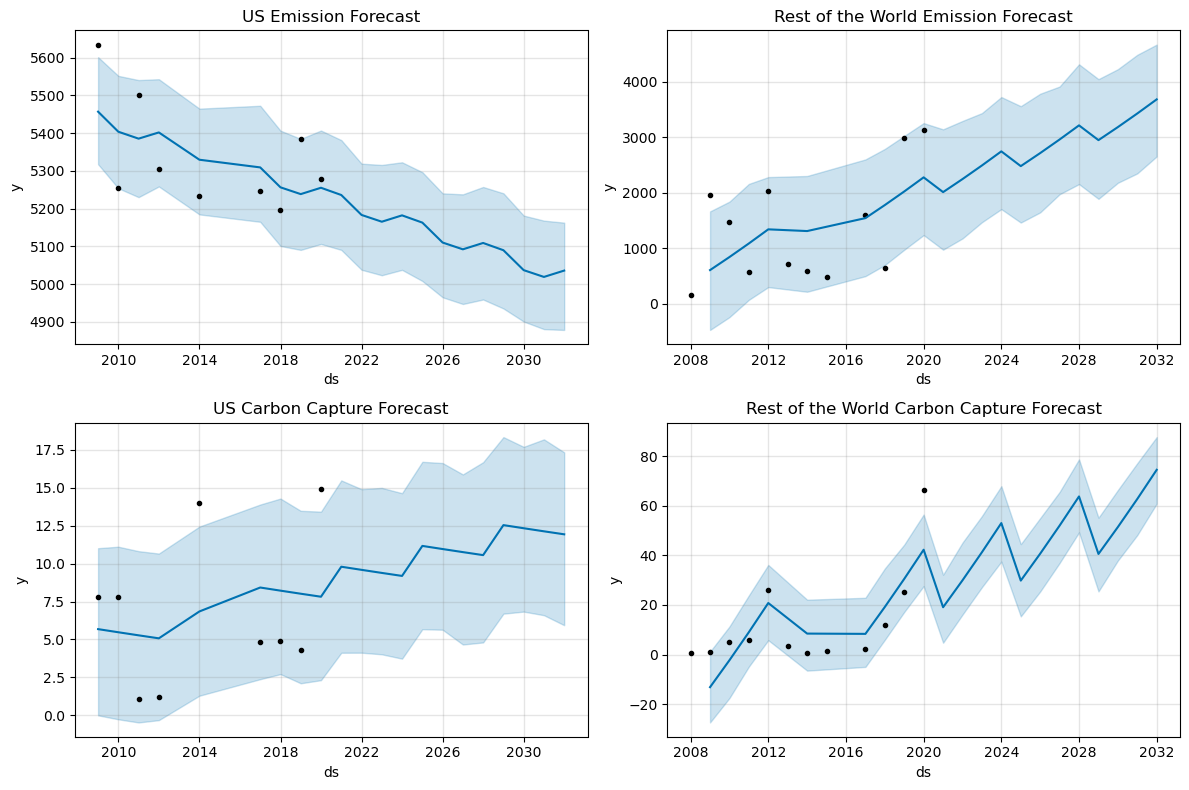

In [75]:
#PLot US and the rest of the world forecast
# Plot forecasts side by side
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(12, 8))

# Plot for the US forecast
us_emission_model.plot(us_emission_forecast, ax=ax[0,0])
ax[0,0].set_title('US Emission Forecast')

# Plot for the World forecast
world_emission_model.plot(world_emission_forecast, ax=ax[0,1])
ax[0,1].set_title('Rest of the World Emission Forecast')

us_cc_model.plot(us_cc_forecast, ax=ax[1,0])
ax[1,0].set_title('US Carbon Capture Forecast')

# Plot for the World forecast
world_cc_model.plot(world_cc_forecast, ax=ax[1,1])
ax[1,1].set_title('Rest of the World Carbon Capture Forecast')
# Show the plots

plt.show()



